Let's solve simple equation oscillator

\begin{equation}
\frac{df}{d t} = (i\omega -2\lambda t) f
\end{equation}

In [1]:
from sympy import symbols, init_printing, diff, sin, cos, exp, I
init_printing()
omega, lam, t, A = symbols("omega, lambda, t, A")
f = A*exp(-lam*t**2+I*omega*t)
f

In [2]:
lhs = diff(f, t)
rhs = (-2*lam*t+I*omega)*f
lhs

In [3]:
eq = lhs - rhs
eq

Let's get the derivative of a poorly sampled function as precicely as we can.

In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def Dt_naive(f, t):
    dt = t[1]-t[0]
    Nt = len(t)
    fp = np.zeros(Nt, complex)
    # fp[0] = (f[1]-f[0])/dt
    for i in range(1, Nt):
        fp[i] = (f[i]-f[i-1])/dt
    return fp

Let's get the differentiation coefficients

In [6]:
from sympy import zeros, factorial, solve, Integer, Matrix, pprint
def get_coeffs(order, accur, direction="backward"):
    points = order+accur

    if direction == "backward":
        s = Matrix([Integer(i) for i in range(-points+1, 1)]).transpose()
    elif direction == "forward":
        s = Matrix([Integer(i) for i in range(points)]).transpose()
    elif direction == "central":
        if accur % 2 != 0:
            raise ValueError("accurracy has to be even for centered derivatives.")
        s = Matrix([Integer(i) for i in range(-points/2+1, points/2+1)]).transpose()
    #print s

    S = zeros(points, points)
    for i in range(points):
        S[i, :] = Matrix([s[0, j]**i for j in range(points)]).transpose()

    d = zeros(points, 1)
    d[order] = factorial(order)

    sol = S.inv()*d
    return [i for i in sol]

def calculate_coef_table(accur_max, numeric=True):
    r"""Calculate a table of coefficients for higher accurracy backward derivatives."""
    order = 1
    coef_table = [[0 for ii in range(accur_max+1)] for jj in range(accur_max)]
    for i in range(1, accur_max+1):
        tab = get_coeffs(order, i, "backward")
        coef_table[i-1][accur_max+1-(order+i):] = tab

    coef_table = [coef_table[jj][:accur_max+1] for jj in range(accur_max)]
    if numeric:
        coef_table = np.array([[float(coef_table[ii][jj])
                                for jj in range(accur_max+1)]
                                for ii in range(accur_max)])
    return coef_table


In [26]:
accur_max = 10
coef_table = calculate_coef_table(accur_max, numeric=False)

pprint(Matrix(coef_table), num_columns=150)
print

⎡ 0      0     0      0      0      0       0      0     0    -1    1  ⎤
⎢                                                                      ⎥
⎢ 0      0     0      0      0      0       0      0    1/2   -2   3/2 ⎥
⎢                                                                      ⎥
⎢ 0      0     0      0      0      0       0    -1/3   3/2   -3   11/6⎥
⎢                                                                      ⎥
⎢                                                                   25 ⎥
⎢ 0      0     0      0      0      0      1/4   -4/3    3    -4    ── ⎥
⎢                                                                   12 ⎥
⎢                                                                      ⎥
⎢                                                                  137 ⎥
⎢ 0      0     0      0      0     -1/5    5/4   -10/3   5    -5   ─── ⎥
⎢                                                                   60 ⎥
⎢                                                  

The anti-diagonals of this matrix have a certain structure. The denominator is `accur+n` with an alternating sign, while the numerators for the first three anti-diagonalsare 1, `accur`, and triangular numbers.

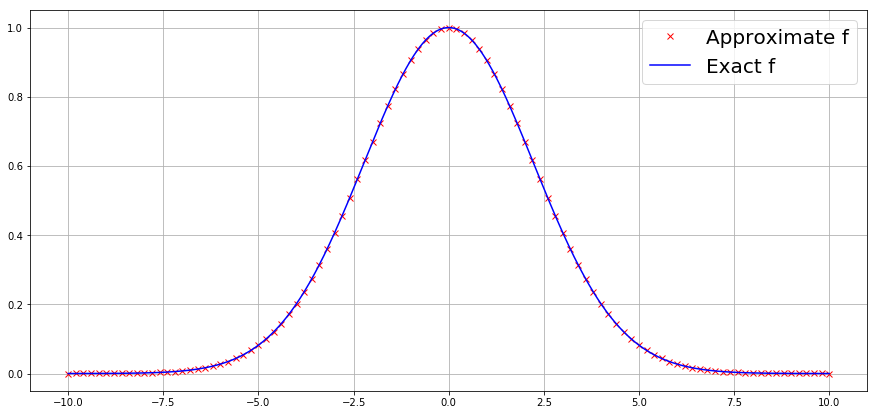

In [107]:
Nsample = 101
Nsample_cont = 1001
a = 10.0
t = np.linspace(-a, a, Nsample)
t_exact = np.linspace(-a, a, Nsample_cont)

lami = 5.0; lamr = 0.25; lam = lamr + 1j*lami
lam = 0.1
omega = 2.5
omega = 0.0
f = np.exp(-lam*t**2 + 1j*omega*t)
f_exact = np.exp(-lam*t_exact**2 + 1j*omega*t_exact)

plt.figure(figsize=(15, 7))
plt.plot(t, np.real(f), "rx", label="Approximate f")
plt.plot(t_exact, np.real(f_exact), "b-", label="Exact f")
plt.legend(fontsize=20)
plt.grid(True)

In [108]:
def Dt_order(f, t, coef_table, accur=1):
    r"""A backward derivative with accurracy `accur`."""
    dt = t[1]-t[0]
    max_accur = len(coef_table)
    coefs = coef_table[accur-1][max_accur-accur:]
    return sum([coefs[j]*f[j] for j in range(accur + 1)])/dt


def _bounds(ii, accur_max, NN):
    if ii <= accur_max:
        return (0, ii+1)
    else:
        return (ii-accur_max, ii+1)


101 101


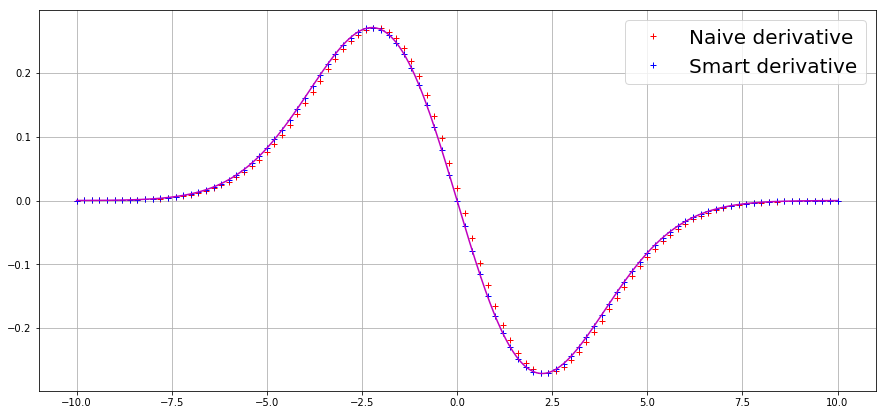

In [109]:
#lhs_smart = Dt_order(f, t, 6)
#Dt = define_Dt(10)
#lhs_smart = Dt(f, t)
rhs = (-2*lam*t+1j*omega)*f
rhs_exact = (-2*lam*t_exact+1j*omega)*f_exact

lhs_exact = (-2*lam*t_exact+1j*omega)*f_exact
lhs_naive = Dt_naive(f, t)

lhs_smart = np.zeros(len(f), f.dtype)
accur_max = 10
NN = len(t)
coef_table = calculate_coef_table(accur_max)
for ii in range(1, NN):
    a, b = _bounds(ii, accur_max, NN)
    lhs_smart[ii] = Dt_order(f[a:b], t[a:b], coef_table, min(ii, accur_max))

#print 111, lhs_smart
print len(t), len(lhs_smart)

plt.figure(figsize=(15, 7))
plt.plot(t, np.real(lhs_naive), "r+", label="Naive derivative")
plt.plot(t, np.real(lhs_smart), "b+", label="Smart derivative")
plt.plot(t_exact, np.real(lhs_exact), "m-")
plt.legend(fontsize=20)
plt.grid(True)

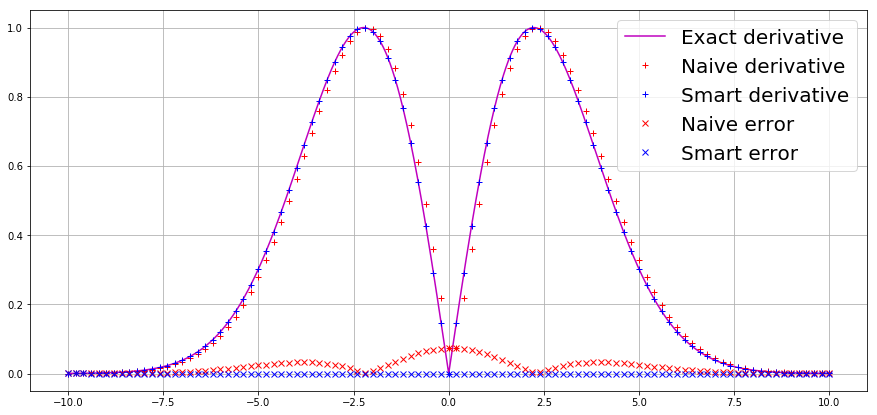

In [110]:
fmax = np.amax(np.abs(lhs_exact))

check_exact_rel = (lhs_exact - rhs_exact)/fmax
check_naive_rel = (lhs_naive-rhs)/fmax

check_smart_rel = (lhs_smart-rhs)/fmax

plt.figure(figsize=(15, 7))

plt.plot(t_exact, np.abs(lhs_exact)/fmax, "m-", label="Exact derivative")
plt.plot(t, np.abs(lhs_naive)/fmax, "r+", label="Naive derivative")
plt.plot(t, np.abs(lhs_smart)/fmax, "b+", label="Smart derivative")

plt.plot(t, np.abs(check_naive_rel), "rx", label="Naive error")
plt.plot(t, np.abs(check_smart_rel), "bx", label="Smart error")
# plt.plot(t_exact, np.abs(check_exact_rel), "m-")

plt.legend(fontsize=20)
plt.grid(True)

worst error: [ 0.07358601  0.00033475]
worst log10 error: [-1.13320472 -3.47528124]

mean error: [  7.30835861e-03   3.15093374e-09]
mean log10 error: [-2.13618015 -8.50156073]


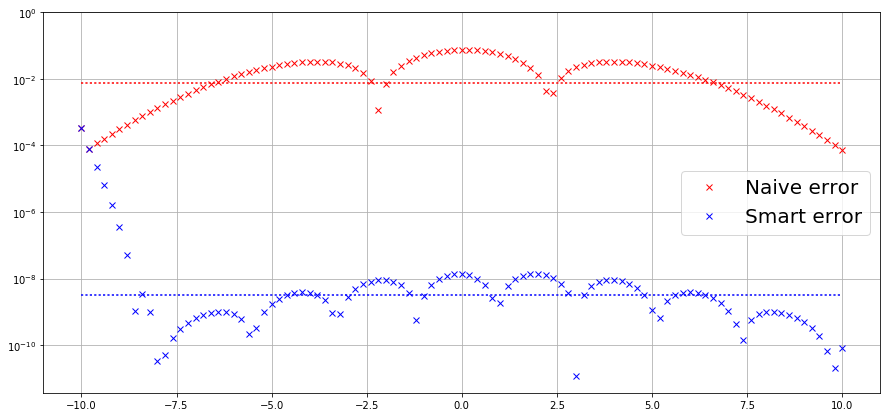

In [113]:
plt.figure(figsize=(15, 7))
# plt.semilogy(t_exact, np.abs(check_exact_rel), "mx")
plt.semilogy(t, np.abs(check_naive_rel), "rx", label="Naive error")
plt.semilogy(t, np.abs(check_smart_rel), "bx", label="Smart error")

error_exact_rel = np.amax(np.abs(check_exact_rel))
error_naive_rel = np.amax(np.abs(check_naive_rel))
error_smart_rel = np.amax(np.abs(check_smart_rel))
errors = np.array([error_naive_rel, error_smart_rel])
mean_errors = np.array([np.mean(np.log10(np.abs(check_naive_rel))),
                        np.mean(np.log10(np.abs(check_smart_rel)))])
print "worst error:", errors
print "worst log10 error:", np.log10(errors)
print
print "mean error:", 10**mean_errors
print "mean log10 error:", mean_errors

plt.semilogy(t, 10**mean_errors[0]*np.ones(len(t)), "r:")
plt.semilogy(t, 10**mean_errors[1]*np.ones(len(t)), "b:")

plt.ylim(None, 1.0)
plt.legend(fontsize=20)
plt.grid(True)

In [ ]:
def Dt_order(f, t, coef_table, accur=1):
    r"""A backward derivative with accurracy `accur`."""
    dt = t[1]-t[0]
    coefs = coef_table[accur-1][-accur-1:]
    # fp = np.zeros(f.shape[0]-accur, f.dtype)
    Nt = len(f)
    N = accur + 1
    rev = list(reversed(range(N)))
    # print 222, N, Nt, rev, accur, coefs
    
    fp = np.zeros(Nt, f.dtype)
    for i in range(accur, Nt):
        fp[i] = sum([coefs[N-j-1]*f[i-j] for j in rev])
    
    fp = fp/dt
    return fp

def define_Dt(accur_max=6):
    order = 1
    coef_table = [[0 for ii in range(accur_max+1)] for jj in range(accur_max)]
    for i in range(1, accur_max+1):
        tab = get_coeffs(order, i, "backward")
        coef_table[i-1][accur_max+1-(order+i):] = tab

    coef_table = [coef_table[jj][:accur_max+1] for jj in range(accur_max)]
    coef_table = np.array([[float(coef_table[ii][jj])
                            for jj in range(accur_max+1)]
                            for ii in range(accur_max)])
    
    # print 111, coef_table.shape
    
    def Dt(f, t):
        dt = t[1]-t[0]
        fp = np.zeros(t.shape[0], f.dtype)
        for i in range(1, accur_max):
            fp[:i+1] += Dt_order(f[:i+1], t[:i+1], coef_table, accur=i)
        fp += Dt_order(f, t, coef_table, accur_max)
        return fp
    
    return Dt


In [106]:
def ffftfreq(t):
    r"""Calculate the angular frequency axis for a given time axis."""
    dt = t[1]-t[0]
    nu = np.fft.fftshift(np.fft.fftfreq(t.size, dt))
    return nu


def ffftfft(f, t):
    r"""Calculate the Fourier transform."""
    dt = t[1]-t[0]
    return np.fft.fftshift(np.fft.fft(np.fft.ifftshift(f)))*dt

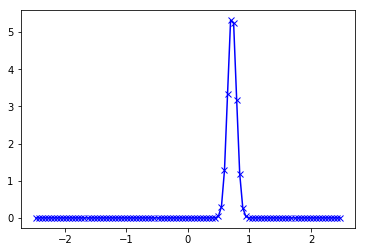

In [110]:
nu = ffftfreq(t)
fhat = ffftfft(f, t)
plt.plot(nu, np.abs(fhat), "bx-")

In [111]:
4.5/2/np.pi

In [536]:
get_coeffs(2, 2, "central")

We check the Wikipedia tables:

In [566]:
a = 8
for order in range(1, 7):
    table= [[0 for ii in range(-a, a+1)] for jj in range(4)]
    for i in range(1, 5):
        tab = get_coeffs(order, 2*i, "central")
        table[i-1][a-i: a+i] = tab
    table = [table[jj][:2*a+1] for jj in range(4)]

    print order
    pprint(Matrix(table), num_columns=150)
    print

1
⎡0  0  0  0    0      0      0    -1/2  0  1/2    0      0      0     0  0  0  0⎤
⎢                                                                               ⎥
⎢0  0  0  0    0      0     1/12  -2/3  0  2/3  -1/12    0      0     0  0  0  0⎥
⎢                                                                               ⎥
⎢0  0  0  0    0    -1/60   3/20  -3/4  0  3/4  -3/20  1/60     0     0  0  0  0⎥
⎢                                                                               ⎥
⎣0  0  0  0  1/280  -4/105  1/5   -4/5  0  4/5  -1/5   4/105  -1/280  0  0  0  0⎦

2
⎡0  0  0  0    0       0      0     1    -2     1     0      0      0     0  0  0  0⎤
⎢                                                                                   ⎥
⎢0  0  0  0    0       0    -1/12  4/3  -5/2   4/3  -1/12    0      0     0  0  0  0⎥
⎢                                                                                   ⎥
⎢                                       -49                                  

Forward derivatives

In [576]:
a = 10
nprec = 6
order = 1
table= [[0 for ii in range(a)] for jj in range(nprec)]
for order in range(1, 5):
    for i in range(1, nprec+1):
        tab = get_coeffs(order, i, "forward")
        table[i-1][:order+i] = tab
    table = [table[jj][:a] for jj in range(nprec)]

    print order
    pprint(Matrix(table), num_columns=150)
    print

1
⎡ -1    1    0     0      0     0    0    0  0  0⎤
⎢                                                ⎥
⎢-3/2   2  -1/2    0      0     0    0    0  0  0⎥
⎢                                                ⎥
⎢-11/6  3  -3/2   1/3     0     0    0    0  0  0⎥
⎢                                                ⎥
⎢-25                                             ⎥
⎢────   4   -3    4/3   -1/4    0    0    0  0  0⎥
⎢ 12                                             ⎥
⎢                                                ⎥
⎢-137                                            ⎥
⎢─────  5   -5    10/3  -5/4   1/5   0    0  0  0⎥
⎢  60                                            ⎥
⎢                                                ⎥
⎢-49                                             ⎥
⎢────   6  -15/2  20/3  -15/4  6/5  -1/6  0  0  0⎥
⎣ 20                                             ⎦

2
⎡ 1     -2      1      0      0      0     0      0    0  0⎤
⎢                                                          ⎥
⎢ 2   

Backward derivatives

In [579]:
a = 10
nprec = 6
order = 1
table= [[0 for ii in range(a)] for jj in range(nprec)]
for order in range(1, 5):
    for i in range(1, nprec+1):
        tab = get_coeffs(order, i, "backward")
        table[i-1][a-(order+i):] = tab
    table = [table[jj][:a] for jj in range(nprec)]

    print order
    pprint(Matrix(table), num_columns=150)
    print

1
⎡0  0  0   0    0     0      0     0    -1   1  ⎤
⎢                                               ⎥
⎢0  0  0   0    0     0      0    1/2   -2  3/2 ⎥
⎢                                               ⎥
⎢0  0  0   0    0     0    -1/3   3/2   -3  11/6⎥
⎢                                               ⎥
⎢                                            25 ⎥
⎢0  0  0   0    0    1/4   -4/3    3    -4   ── ⎥
⎢                                            12 ⎥
⎢                                               ⎥
⎢                                           137 ⎥
⎢0  0  0   0   -1/5  5/4   -10/3   5    -5  ─── ⎥
⎢                                            60 ⎥
⎢                                               ⎥
⎢                                            49 ⎥
⎢0  0  0  1/6  -6/5  15/4  -20/3  15/2  -6   ── ⎥
⎣                                            20 ⎦

2
⎡0  0    0     0      0     0      0       1     -2     1  ⎤
⎢                                                          ⎥
⎢0  0    0     0      0

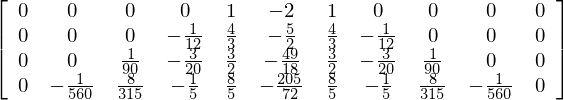

In [544]:
table= [[0 for ii in range(-5, 5)] for jj in range(4)]
for i in range(1, 5):
    tab = get_coeffs(2, 2*i, "central")
    table[i-1][5-i: 5+i] = tab
table = [table[jj][:11] for jj in range(4)]
    
Matrix(table)

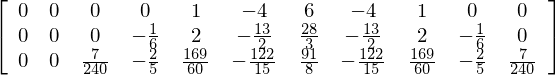

In [549]:
table= [[0 for ii in range(-5, 5)] for jj in range(3)]
for i in range(1, 4):
    tab = get_coeffs(4, 2*i, "central")
    table[i-1][5-i: 5+i] = tab
table = [table[jj][:11] for jj in range(3)]
    
Matrix(table)

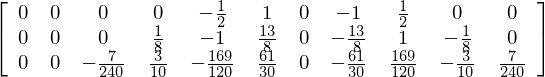

In [548]:
table= [[0 for ii in range(-5, 5)] for jj in range(3)]
for i in range(1, 4):
    tab = get_coeffs(3, 2*i, "central")
    table[i-1][5-i: 5+i] = tab
table = [table[jj][:11] for jj in range(3)]
    
Matrix(table)

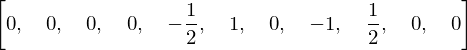

In [542]:
table[0]

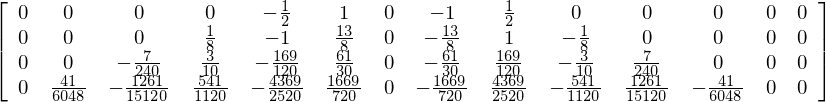

In [505]:
table= [[0 for i in range(-5, 4)] for j in range(4)]
for i in range(1, 5):
    tab = get_coeffs(2, 2*i, "central")
    table[i-1][5-i: 5+i] = tab
    
Matrix(table)

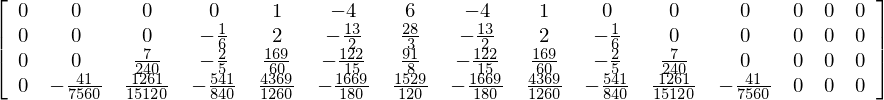

In [506]:
table= [[0 for i in range(-5, 6)] for j in range(4)]
for i in range(1, 5):
    tab = get_coeffs(4, 2*i, "central")
    table[i-1][5-i: 5+i] = tab
    
Matrix(table)

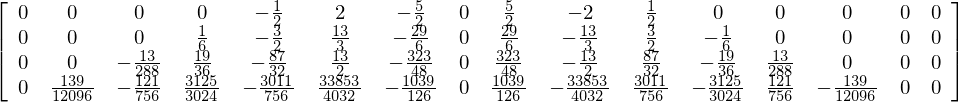

In [507]:
table= [[0 for i in range(-5, 6)] for j in range(4)]
for i in range(1, 5):
    tab = get_coeffs(5, 2*i, "central")
    table[i-1][5-i: 5+i] = tab
    
Matrix(table)

In [436]:
for i in range(1, 7):
    print get_coeffs(1, i)

[-1, 1]
[-3/2, 2, -1/2]
[-11/6, 3, -3/2, 1/3]
[-25/12, 4, -3, 4/3, -1/4]
[-137/60, 5, -5, 10/3, -5/4, 1/5]
[-49/20, 6, -15/2, 20/3, -15/4, 6/5, -1/6]


In [414]:
from sympy import Function
from sympy import series, factorial
from sympy import Order, KroneckerDelta
f = Function("f")
t, tp = symbols("t, t'", real=True)
h = symbols("h", positive=True)

order = 1
accur = 2
N = order + accur
backward = True
backward = False
if backward:
    points = [t+h*i for i in range(-N+1, 1)]
else:
    points = [t+h*i for i in range(N)]
points

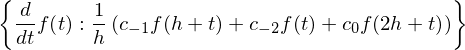

In [415]:
c = symbols(''.join(["c_{"+str(i)+"} " for i in range(-N+1, 1)]))
eq = diff(f(t), t, order)
eq_lhs = diff(f(t), t, order)
eq_rhs = sum([c[i]*f(points[i]) for i in range(N)])*h**-order
{eq_lhs: eq_rhs}

We expand $f$ up to the desired precision and substitute in the points above

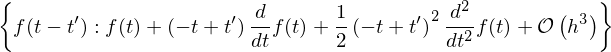

In [416]:
def my_series(f, a, tp, accur):
    terms = sum([(tp-a)**i*diff(f(t), t, i)/factorial(i) for i in range(accur)])
    #print a, tp, accur
    terms += Order(h**accur)
    return terms

f_series = my_series(f, t, tp, N)
{f(t-tp): f_series}

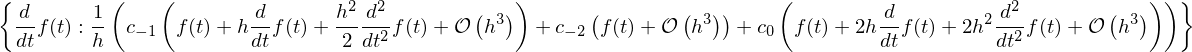

In [417]:
eq_rhs = sum([c[i]*f_series.subs(tp, points[i]) for i in range(N)])*h**-order
{eq_lhs: eq_rhs}

We can see this equation as $N$ equations for separate derivatives

\begin{equation}
    \sum_j A_{ij} c_j = \frac{d^i f}{d t^i}
\end{equation}

with $i, j\in [-N, \cdots, 0]$

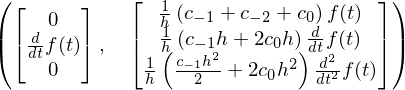

In [418]:
i = 0
eqs_rhs = Matrix([diff(eq_rhs, diff(f(t), t, i))*diff(f(t), t, i) for i in range(N)])
eqs_lhs = Matrix([diff(f(t), t, i)*KroneckerDelta(i, order) for i in range(N)])
eqs_lhs, eqs_rhs

If we think of this as a vectorspace whose basis vectors are each of the derivatives, these $N$ equations have a matrix representation.

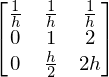

In [419]:
A = Matrix([[diff(eqs_rhs[i], c[j])/diff(f(t), t, i) for j in range(N)] for i in range(N)])
A

In [420]:
b = Matrix([eqs_lhs[i]/diff(f(t), t, i) for i in range(N)])
b

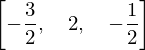

In [421]:
sol = A.inv()*b
sol = [i for i in sol]
sol

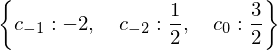

In [411]:
sol_dict = {c[i]: sol[i] for i in range(N)}
sol_dict

We check that this is in deed a solution to our equation.

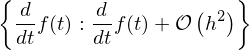

In [412]:
{eq_lhs: eq_rhs.subs(sol_dict).expand()}

In [323]:
eq_rhs = sum([c[i]*f_series.subs(tp, points[i]) for i in range(npoints)])
eq_rhs = diff(eq_rhs, diff(f(t), t, 0))
eq_rhs

In [281]:
Order(t)

In [184]:
for i in range(1, 7):
    print get_coeffs(1, i)

⎡0⎤
⎢ ⎥
⎣1⎦
[-1, 1]
⎡0⎤
⎢ ⎥
⎢1⎥
⎢ ⎥
⎣0⎦
[-1/2, 0, 1/2]
⎡0⎤
⎢ ⎥
⎢1⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦
[1/6, -1, 1/2, 1/3]
⎡0⎤
⎢ ⎥
⎢1⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦
[-1/12, 1/2, -3/2, 5/6, 1/4]
⎡0⎤
⎢ ⎥
⎢1⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦
[1/20, -1/3, 1, -2, 13/12, 1/5]
⎡0⎤
⎢ ⎥
⎢1⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦
[-1/30, 1/4, -5/6, 5/3, -5/2, 77/60, 1/6]
